In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import timedelta
import xarray as xr
from glob import glob
import sys, os
import cartopy
cartopy.config['pre_existing_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
cartopy.config['repo_data_dir'] = '/home1/datawork/kbalem/cartopy_shapefiles/'
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='50m',facecolor=[0.4,0.6,0.7])
pr1=ccrs.PlateCarree()

In [19]:
dout=xr.open_zarr('/home1/scratch/kbalem/lk70y00f.zarr')
dout.load()

<xarray.Dataset> Size: 11MB
Dimensions:       (trajectory: 280, obs: 717)
Coordinates:
  * obs           (obs) int32 3kB 0 1 2 3 4 5 6 ... 710 711 712 713 714 715 716
  * trajectory    (trajectory) int64 2kB 280 281 282 283 284 ... 556 557 558 559
Data variables:
    cycle_age     (trajectory, obs) float32 803kB 300.0 2.1e+03 ... 4.251e+05
    cycle_number  (trajectory, obs) float64 2MB 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0
    cycle_phase   (trajectory, obs) float64 2MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0
    in_water      (trajectory, obs) float32 803kB 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat           (trajectory, obs) float64 2MB 32.0 32.0 32.0 ... 41.7 41.7
    lon           (trajectory, obs) float64 2MB -17.0 -17.0 ... -10.19 -10.19
    time          (trajectory, obs) datetime64[ns] 2MB 2008-04-01T12:00:00 .....
    z             (trajectory, obs) float64 2MB 2.5 164.5 326.5 ... 1e+03 1e+03
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

In [20]:
mask = xr.open_dataset('data/mask_glorys.nc')
mask = mask.rename({'__xarray_dataarray_variable__':'depth'})
mask['longitude'].values[mask['longitude'].values>180] -= 360
mask = mask.sortby(['longitude','latitude'])
mask

<xarray.Dataset> Size: 8MB
Dimensions:    (latitude: 689, longitude: 1440)
Coordinates:
    time       datetime64[ns] 8B ...
  * latitude   (latitude) float32 3kB -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB -179.9 -179.6 -179.4 ... 179.6 179.9
Data variables:
    depth      (latitude, longitude) int64 8MB ...

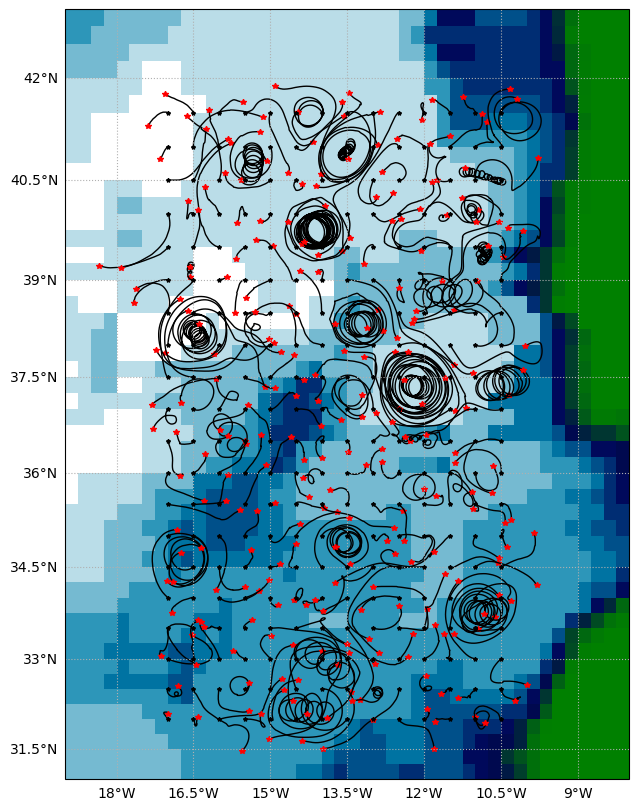

In [21]:
extent = [-19,-8,31,43]

fig=plt.figure(figsize=(12,10))
pr1=ccrs.PlateCarree()
pr2=ccrs.Mercator()

ax1 = fig.add_subplot(projection=pr2)
a=ax1.pcolormesh(mask.longitude,mask.latitude,mask['depth'],shading='auto',transform=pr1,cmap=plt.get_cmap('ocean'),vmin=0)
#ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False
for t in range(len(dout.trajectory.values)):
    ax1.plot(dout['lon'].isel(obs=0,trajectory=t),dout['lat'].isel(obs=0,trajectory=t),'k*',markersize=3,transform=pr1,zorder=10)
    ax1.plot(dout['lon'].isel(trajectory=t),dout['lat'].isel(trajectory=t),'k',linewidth=1,transform=pr1)
    ax1.plot(dout['lon'].isel(trajectory=t, obs=-1),dout['lat'].isel(trajectory=t, obs=-1),'r*',markersize=4,transform=pr1)
ax1.set_extent(extent)

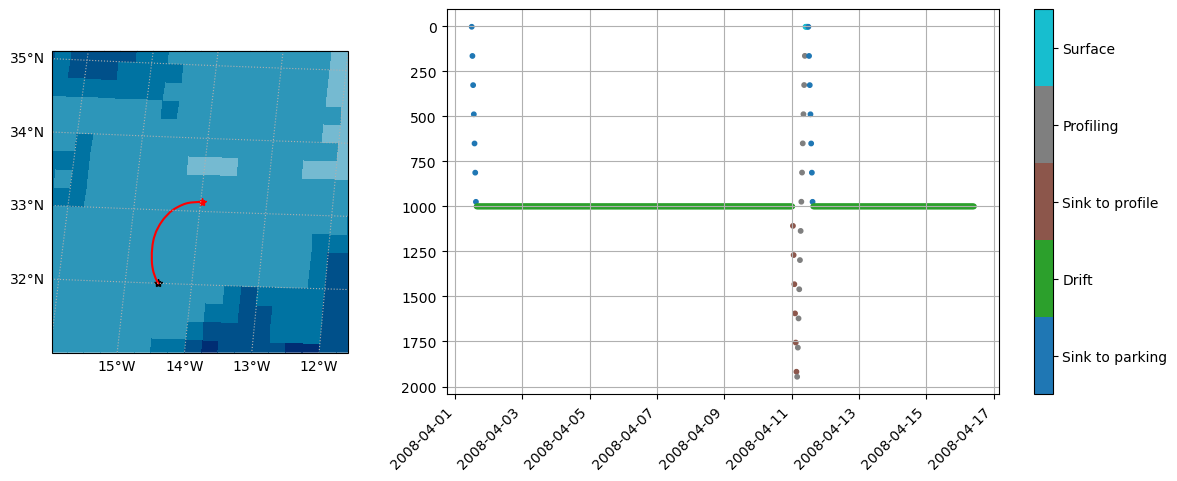

In [23]:
tr=100

fig=plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(1,2,width_ratios=[.6,1.4])
pr1=ccrs.PlateCarree()
pr2=ccrs.LambertAzimuthalEqualArea()
ax1 = fig.add_subplot(gs[0], projection=pr2)
ax1.pcolormesh(mask.longitude,mask.latitude,mask['depth'],shading='auto',transform=pr1,cmap=plt.get_cmap('ocean'),vmin=0)
ax1.coastlines(resolution='110m',zorder=10)
ga=ax1.gridlines(linestyle=':',draw_labels=True)
ga.top_labels, ga.right_labels = False, False

ax1.plot(dout['lon'].isel(trajectory=tr,obs=0),dout['lat'].isel(trajectory=tr,obs=0),'k*',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr),dout['lat'].isel(trajectory=tr),'r',transform=pr1)
ax1.plot(dout['lon'].isel(trajectory=tr,obs=-1),dout['lat'].isel(trajectory=tr,obs=-1),'r*',transform=pr1)
extent=[dout['lon'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lon'].isel(trajectory=tr,obs=-1).max().values +2,
        dout['lat'].isel(trajectory=tr,obs=-1).min().values -2,
        dout['lat'].isel(trajectory=tr,obs=-1).max().values +2]
ax1.set_extent(extent)

ax = fig.add_subplot(gs[1])
a=ax.scatter(dout['time'].isel(trajectory=tr),dout['z'].isel(trajectory=tr),s=10,c=dout['cycle_phase'].isel(trajectory=tr),cmap=plt.get_cmap('tab10',5),vmin=0,vmax=5)
ax.invert_yaxis()
_=plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(':')
#ax.set_xlim([np.datetime64('2011-01-15'),np.datetime64('2011-01-16')])
cb=plt.colorbar(a,ticks=[0.5,1.5,2.5,3.5,4.5])
cb.set_ticklabels(['Sink to parking','Drift','Sink to profile','Profiling','Surface'])